In [1]:
# This notebook will do the correlation analysis between protein and cell specific grwoth rate for individual gene
import pandas as pd
import numpy as np
from scipy import stats
from statsmodels.stats import multitest

C:\Users\bioex\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [8]:
# Preparing data for doing the correlation analysis
protein_data = pd.read_excel("pvsm.xlsx",sheet_name="Protome",index_col=0)
protein_data = protein_data.iloc[:,1:10]
protein_data = protein_data.T
specific_growth_rates = [0.027, 0.044, 0.102, 0.152, 0.214, 0.254, 0.284, 0.334, 0.379]

In [36]:
# Do the correlation analysis of individual proteins vs specific growth rate
p_names=protein_data.columns
names=[]
corrcoefs=[]
pvalues=[]
for name in p_names:
    if isinstance(name,float):#isinstance function for eliminating empty name
        continue
    protein = protein_data[name]        
    available_protein_num = sum(~protein.isna())
    if available_protein_num<3 or name in ['YPR124W','YGR027C']:
        continue
    corr,p=stats.spearmanr(specific_growth_rates,protein,nan_policy='omit')
    names.append(name)
    corrcoefs.append(corr)
    pvalues.append(p)
print("There are %d proteins available, but only %d has valid correaltion coef"%(len(p_names),len(names)))
pvsmu_correlation_df = pd.DataFrame({'Name':names,'coef':corrcoefs,'pvalue':pvalues})

There are 3347 proteins available, but only 2018 has valid correaltion coef


In [52]:
# Output the correlation table and do FDR correction of p values
res=multitest.multipletests(pvsmu_correlation_df.pvalue,method='fdr_tsbky')
corrected_pvsmu_correlation_df=pvsmu_correlation_df.iloc[res[0],:]
pvsmu_correlation_df['pcorr']=res[1]
pvsmu_correlation_df['FDR<0.05']=res[0]
pvsmu_correlation_df.to_csv('corrected_pvsmu_correlation.csv')
significant_correlated_df = pvsmu_correlation_df[pvsmu_correlation_df['FDR<0.05']]
pos_correlated_df = significant_correlated_df[significant_correlated_df['coef']>0]
neg_correlated_df = significant_correlated_df[significant_correlated_df['coef']<0]
pos_cor_val=pos_correlated_df.coef.values
neg_cor_val=neg_correlated_df.coef.values
print("Siginficant positive correlations:%d\nSignificant negative correlations:%d"%(len(pos_cor_val),len(neg_cor_val)))

Siginficant positive correlations:528
Significant negative correlations:450


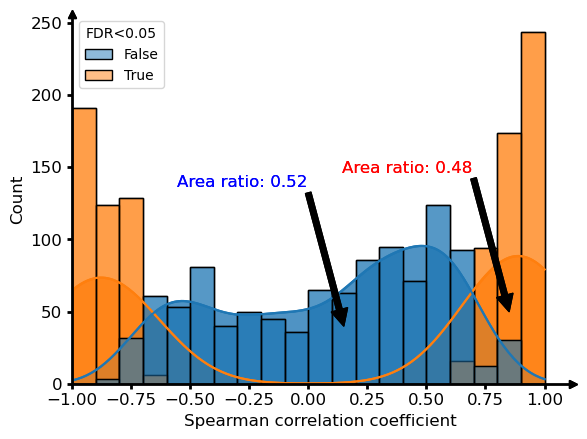

In [53]:
# hist plot of the correlation coefficient distribution between protein/mRNA pair
import matplotlib.pyplot as plt
import seaborn as sns

#Do the hist plot
ax=sns.histplot(pvsmu_correlation_df,bins=20,x="coef",hue="FDR<0.05",kde=True)#,color='black',hist_kws={'linewidth':2,'edgecolor':'black','facecolor':'white'})

#Setting filled density curves
for l in ax.lines:
    x1 = l.get_xydata()[:,0]
    y1 = l.get_xydata()[:,1]
    ax.fill_between(x1,y1,color=l.get_color(),alpha=0.4)
#Set x axis limit
ax.set_xlim(-1,1.1)
#Prepare for annotation in figure
ratio_accepted = sum(pvsmu_correlation_df["FDR<0.05"])/len(pvsmu_correlation_df["FDR<0.05"])
ratio_rejected = 1 - ratio_accepted
str_accepted = 'Area ratio: %0.2f'%ratio_accepted
str_rejected = 'Area ratio: %0.2f'%ratio_rejected
#Do annotation for the two density distribution curves
ax.annotate(str_accepted,(0.85,50),(-120,100),textcoords='offset points',color='red',fontsize=12,arrowprops=dict(color='black'))
ax.annotate(str_rejected,(0.15,40),(-120,100),textcoords='offset points',color='blue',fontsize=12,arrowprops=dict(color='black'))

#Formatting the figure
ax.set_xlabel('Spearman correlation coefficient',fontsize=12)
ax.set_ylabel('Count',fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax.xaxis.set_tick_params(width=2)
ax.yaxis.set_tick_params(width=2)
ax.spines.top.set_visible(False)
ax.spines.right.set_visible(False)
ax.spines.bottom.set_linewidth(2)
ax.spines.left.set_linewidth(2)
ax.plot(1.01,0,">k",transform=ax.get_yaxis_transform(),clip_on=False)
ax.plot(-1,1,"^k",transform=ax.get_xaxis_transform(),clip_on=False)

plt.show()
#plt.savefig('Fig_protein_mu_correlation_hist.png',dpi=300,format='png')